In [12]:
# Imports 
import time
import os
import re
import json
import collections

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from fuzzywuzzy import fuzz
import pandas as pd
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
nlp = spacy.load('en')

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp, blacklist=True)


# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

[nltk_data] Downloading package stopwords to /home/dmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as nnf
tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original", return_dict=True)
import numpy as np
emotions = ['admiration','amusement','anger','annoyance','approval','caring','confusion','curiosity',\
            'desire','disappointment','disapproval','disgust','embarrassment','excitement','fear',\
            'gratitude','grief','joy','love','nervousness','optimism','pride','realization','relief',\
            'remorse','sadness','surprise','neutral']
reduced_emotions = {
    'admiration' : 'pos',
 'amusement' : 'pos',
 'anger' : 'neg',
 'annoyance' : 'neg',
 'approval' : 'pos',
 'caring' : 'pos',
 'confusion' : 'amb',
 'curiosity' : 'amb',
 'desire' : 'pos',
 'disappointment' : 'neg',
 'disapproval' : 'neg',
 'disgust' : 'neg',
 'embarrassment' : 'neg',
 'excitement' : 'pos',
 'fear' : 'neg',
 'gratitude' : 'pos',
 'grief' : 'neg',
 'joy' : 'pos',
 'love' : 'pos',
 'nervousness' : 'neg',
 'optimism' : 'pos',
 'pride' : 'pos',
 'realization' : 'amb',
 'relief' : 'pos',
 'remorse' : 'neg',
 'sadness' : 'neg',
 'surprise' : 'amb',
 'neutral' : 'amb'
}

In [3]:
'''
A class reresenting a mention of some entity. 
It consists of a text string, starting and ending indices
of the text span and a paragraph and sentence id. 
'''
class Mention:
    def __init__(self, text, start, end, par_id, sent_id, global_sentence_id):
        self.text =  text
        self.start = start
        self.end = end
        self.par_id = par_id
        self.sent_id = sent_id
        self.global_sentence_id = global_sentence_id
        self.POS = []
        self.deps = set()
        
    def __repr__(self):
        rep = "Mention in par " + str(self.par_id) + " Sentence " \
              + str(self.sent_id) + "(Global Sentence "+self.global_sentence_id + ")\n" + self.text
        return rep

'''
A class reresenting a character. 
It consists of a list of mentions, a set of aliases, 
a list of verbs that the character is the actor of (agent),
a list of verbs that the character is the receiver of (patient),
a list of adjectives that the character is described with (description).  
'''
class Character:
    def __init__(self, book, mainName):
        self.book = book
        self.mainName = mainName
        self.mentions = []
        self.unique_sents = {}
        self.aliases = set()
        self.agent = {}
        self.patient = {}
        self.description = {}
        
    def __repr__(self):
        rep = "Character: " + self.mainName + "\n"
        return rep
    
    def to_json(self):
        return {"mainName" : self.mainName,
                "mentions" : [mention.text for mention in self.mentions],
                "aliases" : list(self.aliases),
                "agent" : [{str(list(loc)) : verb} for loc, verb in self.agent.items()],
                "patient" : [{str(list(loc)) : verb} for loc, verb in self.patient.items()],
        }
    
    '''
    Add a mention of the character to a list of mentions.
    '''
    def update_mention(self, mention):
        self.mentions.append(mention)
        self.aliases.update([mention.text.lower()])
        
    '''
    Match POS tags with character mentions
    '''
    def get_POS(self):
        for mention in self.mentions:
            span = range(mention.start, mention.end)
            for loc in span:
                mention.POS.append(self.book.pars[mention.par_id].POS_tags[loc])
                mention.deps.update([mention.POS[-1]['dep']])
                
    def get_unique_sent_mentions(self):
        for mention in self.mentions:
            self.unique_sents[(mention.par_id, mention.sent_id, mention.global_sentence_id)] = \
            self.book.pars[mention.par_id].sents[mention.sent_id].text
                
    '''
    Function to find the verbs in sentences in which the character is mentioned 
    as the nsubj.
    '''
    def get_agent_verbs(self):
        for mention in self.mentions:
            verb = None
            if 'nsubj' in mention.deps:
                sent_POS_parse = self.book.pars[mention.par_id].sents[mention.sent_id].POS_tags
                for POS in sent_POS_parse:
                    if POS['dep'] == 'ROOT':
                        verb = POS['lemma']
                        # Get location tuple (paragraph, sentence, local idx)
                        global_loc = (mention.par_id, mention.sent_id, POS['loc'])
                if verb:
                    self.agent[global_loc] = verb
                    
                    
    '''
    Function to find the verbs in sentences in which the character is mentioned 
    as the dobj or nsubjpass.
    '''
    def get_patient_verbs(self):
        for mention in self.mentions:
            verb = None
            if ('dobj' in mention.deps) or ('nsubjpass' in mention.deps):
                sent_POS_parse = self.book.pars[mention.par_id].sents[mention.sent_id].POS_tags
                for POS in sent_POS_parse:
                    if POS['dep'] == 'ROOT':
                        verb = POS['lemma']
                        # Get location tuple (paragraph, sentence, local idx)
                        global_loc = (mention.par_id, mention.sent_id, POS['loc'])
                if verb:
                    self.patient[global_loc] = verb
                    

class Sentence:
    def __init__(self, book, par, text, sent_id, bound):
        # Parent objects
        self.book = book
        self.par = par
        # starting and ending boundary for the sentence (relative to the paragraph)
        self.start = bound[0]
        self.end = bound[1]
        # Global starting and ending indices
        self.globalStart = self.par.start + self.start
        self.globalEnd = self.par.start + self.end 
        self.text = text
        self.sent_id = sent_id
        self.POS_tags = []
        
    def __repr__(self):
        rep = self.book.fileName + "\nParagraph " + str(self.par.par_id) \
        + "\nSentence " + str(self.sent_id) + " start " + str(self.start) \
        + " end " + str(self.end) + "\ntext:\n" + self.text
        return rep
        
'''
A class for a paragraph.
'''
class Paragraph:
    def __init__(self, book, text, par_id, bound):
        # Starting and ending indices for the paragraph
        self.start = bound[0]
        self.end = bound[1]
        # Refers to book parent object
        self.book = book
        # paragraph text
        self.text = text
        # paragraph index
        self.par_id = par_id
        # bool idnicating whether coref wroked
        self.has_coref = False
        # coref cluster list
        self.coref_clusts = []
        # list of sentences
        self.sents = []
        self.number_of_sentences = 0
        self.sent_bounds = []
        self.POS_tags = []
        
    def __repr__(self):
        rep = self.book.fileName + "\nParagraph " + str(self.par_id) + "\ntext:\n" + self.text
        return rep

        
    def run_coref_POS_sent_parse(self, global_sentence_begin=0):
        # Get coreference tags:
        doc = nlp(self.text)
        
        # parse into sentences
        sentences = [sent for sent in doc.sents]
        self.sents = [Sentence(self.book, self, sent.text, 
                               sent_id, (sent.start, sent.end)) 
                      for sent_id, sent in enumerate(sentences)]
        self.number_of_sentences = len(sentences)
        # Keep track of sentence IDs in the context of the whole document
        global_sentence_end = global_sentence_begin + self.number_of_sentences - 1
        self.sent_bounds = [global_sentence_begin, global_sentence_end]
        global_sentence_begin = global_sentence_end + 1
        
        # Update whether the coref parser returned results
        self.has_coref = doc._.has_coref
        if doc._.has_coref:
            self.coref_clusts = doc._.coref_clusters
            self.book.parse_coref_clusts(self)
        # Get POS tags:

        # this uses the pretrained BERT model:
        # book[idx]["POS_tags"] = nlp_token_class(sentence)

        # For now we will use Spacy pos tagging because it gives us more fine-grained labels:
        self.POS_tags = []
        # Add POS tags to list for paragraph and for each individual sentence
        for token_id in range(len(doc)):
            token = doc[token_id]
            sent_id = 0
            for sent in self.sents:
                if ((token_id >= sent.start) and (token_id <= sent.end)):
                        sent_id = sent.sent_id
            self.sents[sent_id].POS_tags.append({
                'loc' : token_id,
                'text' : token.text,
                'lemma' : token.lemma_,
                'pos' : token.pos_, 
                'tag' : token.tag_, 
                'dep' : token.dep_})
            self.POS_tags.append({
                'loc' : token_id,
                'text' : token.text,
                'lemma' : token.lemma_,
                'pos' : token.pos_, 
                'tag' : token.tag_, 
                'dep' : token.dep_})
        return global_sentence_begin 


'''
A class representing a book.
'''        
class Book:
    def __init__(self, dataPath, fileName):
        self.dataPath = dataPath
        self.fileName = fileName
        self.text = ''
        self.characters = {}
        self.char_mention_counts = collections.Counter()
        self.top_characters = {}
        self.pars = []
        self.read_file()
      
    '''
    A function for writing the book object to disk as a json file. Top indicates 
    whether we should just export top mentioned characters or all characters.
    '''
    def to_json(self, outFilename, top=False):
        if not top:
            representation = {"fileName" : self.fileName,
                               "numPars" : len(self.pars),
                   "characters" : [character.to_json() for characterName, 
                                   character in self.characters.items()]}
        else:
            representation = {"fileName" : self.fileName,
                               "numPars" : len(self.pars),
                   "characters" : [character.to_json() for characterName, 
                                   character in self.top_characters.items()]} 
        with open(outFilename, "w") as outFile:
            json.dump(representation, outFile, separators=(',', ':'), indent=4)
    
    '''
    Read the text of the book from a txt file.
    '''
    def read_file(self):
        with open(os.path.join(self.dataPath, self.fileName), "r") as txtFile:
            self.text = txtFile.read()
        
    '''
    Break the text into paragraphs.
    '''
    def parse_into_pars(self):
        # split on newlines followed by space
        pars = re.split('\n\s', self.text)   
        # Replace newline chars
        pars = [par.replace("\n", " ") for par in pars]
        # Remove empty pars
        pars = [par for par in pars if len(par) > 0]
        
        #Preprocess "paragraphs" that are actually quotes or single lined text
        final_pars = []
        for p,paragraph in enumerate(pars):
            
            if paragraph.count(".")<5:
                if p==0:
                    final_pars.append(paragraph)
                else:
                    final_pars[-1] = final_pars[-1] + " " + paragraph
            else:
                final_pars.append(paragraph)
                
                
        par_bounds = []
        par_loc = 0
        for par in final_pars:
            par_bounds.append(par_loc)
            par_loc += len(par)
        par_bounds.append(par_loc)
        
        
        # Convert each paragraph into a Paragraph
        self.pars = [Paragraph(self, par, par_id, (par_bounds[par_id],
                                                   par_bounds[par_id+1])) 
                     for par_id, par in enumerate(final_pars)]
        
    '''
    Parse the coreference clusters returned from the parsing of a paragraph
    max_fuzz is a parameter for fuzzy string matching of character mentions
    between 0 and 100 used in fuzzywuzzy partial_ratio: 
    https://anhaidgroup.github.io/py_stringmatching/v0.3.x/PartialRatio.html
    '''
    def parse_coref_clusts(self, par, max_fuzz=70):
        clustList = par.coref_clusts
        # Iterate over the coreference clusters
        for idx, cluster in enumerate(clustList):
            # get the main cluster identity
            mainSpan = cluster.main.text.lower()
            # If a character object does not yet exist, create one. 
            # We determine if one exists by fizzy matching the mainspan of the character
            max_fuzz_start = max_fuzz
            max_fuzz_char = ''
            for ch in self.characters:
                pr = fuzz.partial_ratio(mainSpan, ch)
                if pr > max_fuzz:
                    max_fuzz = pr
                    max_fuzz_char = ch
            if max_fuzz > max_fuzz:
                # It is already present
                character = self.characters[max_fuzz_char]
            else:
                character = Character(self, mainSpan)
                # Add it to the dict of characters
                self.characters[mainSpan] = character
                
            for mention in cluster.mentions:
                # figure out which sentence the mention belongs to
                sent_id = 0
                for sent in par.sents:
                    if ((mention.start >= sent.start) and (mention.end <= sent.end)):
                        sent_id = sent.sent_id
                # create a mention object and add it to the character object
                global_sentence_id = par.sent_bounds[0] + sent_id
                mention = Mention(mention.text, mention.start, mention.end, par.par_id, sent_id, global_sentence_id)
                character.update_mention(mention)
                self.char_mention_counts[character.mainName] += 1
                
    def get_top_characters(self, n=5):
        # Get n most mentioned characters
        self.top_characters = self.char_mention_counts.most_common()[:n]
        self.top_characters = {character[0] : self.characters[character[0]]
                               for character in self.top_characters}
                
    '''
    Function to parse the book's text and fill in most of the attributes of the 
    Book data structure. onlyTop is a boolean to indicate whether to process all of
    the character entities found or just the most mentioned ones.
    '''
    def parse_text(self, onlyTop=False):
        self.parse_into_pars()
        global_sent_begin = 0
        for par in self.pars:
            new_global_sent_begin = par.run_coref_POS_sent_parse(global_sent_begin)
            global_sent_begin = new_global_sent_begin
            
        self.get_top_characters()
        if not onlyTop:
            for characterName, character in self.characters.items():
                character.get_POS()
                character.get_agent_verbs()
                character.get_patient_verbs()
                character.get_unique_sent_mentions()
        else: 
            for characterName, character in self.top_characters.items():
                #print("parsed ", characterName)
                character.get_POS()
                character.get_agent_verbs()
                character.get_patient_verbs()
                character.get_unique_sent_mentions()
                
    '''
    Load some of the attributes from already processed data
    need todo
    '''
    def load_from_procesed(self, processedData):
        pass

In [4]:
'''
Function to read metadata json
'''
def get_metadata(metaDataFile):
    with open(metaDataFile,'r') as fob:
        metaBooks = json.load(fob)
    return metaBooks

In [18]:
'''
Function for running the parsing pipeline on an entire dataset.
Inputs:
    DataPath - path to dir with the book txt files
    metaDataFile - json filename with metaData for the dataset
    outDir - directory where outputs will be written
    [every] - bool indicating whether to output all characters
    [top] - bool indicating whether to also output just top characters as a separate set of output file
    [verbose] - bool indicating whether to print progress and timing
    [n] - int determines how many books to run it on if you only want a subset
Outputs:
    no function return value, but resulting json files are written to disk in the outDirs.
'''
def process_data(dataPath, metaDataFile, outDir, every=True, top=True, verbose=False, n=-1):
    
    if not every and not top:
        print("Must be run with at least one of 'every' or 'top' set to True\n")
        return None
    
    metaBooks = get_metadata(metaDataFile)
    
    if verbose:
        time_start = time.time()
        print("Starting parsing " + str(len(metaBooks)) + " books from folder " + dataPath)
        print("Outputing results to " + outDir + "\n")
    
    if every:
        if not os.path.exists(outDir):
            os.makedirs(outDir, exist_ok=True)
        
    if top:
        outDirTop = outDir + "_top_only"
        if not os.path.exists(outDirTop):
            os.makedirs(outDirTop, exist_ok=True)
    
    # n == -1 means try to run it on all data. Otherwise, run it on n books
    if n != -1:
        metaBooks = metaBooks[:n]
    
    # Iterate over books and run pipeline on each
    for bookEntry in metaBooks:
        fileName = bookEntry['filename']
        title = os.path.splitext(fileName)[0]

        # Parse the book
        b = Book(dataPath, fileName)
        if every:
            b.parse_text()
        else:
            b.parse_text(onlyTop=True)

        # write outputs
        if every:
            outFileName = os.path.join(outDir, f'{title}_parsed.json')
            b.to_json(outFileName)
        if top:
            outFileNameTop = os.path.join(outDirTop, f'{title}_parsed_top.json')
            b.to_json(outFileNameTop, top=True)
        # optionally report progress
        if verbose:
            currTimeElapsed = str(round(time.time() - time_start, 1))
            print("Parsed " + title + " time passed " + currTimeElapsed + " secs")
            

In [6]:
'''
Read in parsed books 
'''
def read_parsed_book_data(dataPath):
    data = {}
    for fileName in os.listdir(dataPath):
        with open(os.path.join(dataPath, fileName), 'r') as file:
            data[fileName.split("_parsed_")[0]]=json.load(file)
    print("Read " + str(len(data)) + " books")
    return data

In [25]:
'''
Function to give emotional score for a given text.
'''
def get_emotion(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    probs = nnf.softmax(logits, dim=1).data.numpy().squeeze()
    emotion = emotions[np.argmax(probs)]
    emo_prob = np.max(probs)
    mini_emotion = reduced_emotions[emotion]
    return  emotion, mini_emotion, emo_prob, probs

def get_emotions(book):
    emo_df = pd.DataFrame()
    # Iterate over characters with most mentions
    for character in book.top_characters:
        char_emotion = []
        # Iterate over sentences in which character is mentioned
        for loc, sent in book.top_characters[character].unique_sents.items():
            # Get emotional scores for each sentence with a character mention
            emotion, mini_emotion, emo_prob, probs = get_emotion(sent)
            char_emotion.append([character, loc[0],  loc[1], loc[2], emotion, mini_emotion, emo_prob])
        # Store emotion results in data frame
        char_df = pd.DataFrame(char_emotion, columns =['character', 'paragraph_id','sent_id','global_sent_id', \
                                                      'emotion', 'mini_emotion','emo_prob'])
        emo_df = pd.concat([emo_df,char_df])

    return emo_df

In [27]:
# Define Paths and fileNames:
dataPath = "../../datasets/Gutenberg/txt/"
metaDataFile = "../results/metadata-final.json"
outDir = "../results/book_parses"

# Run pipeline on data path:
process_data(dataPath, metaDataFile, outDir, every=False, top=True, verbose=True, n=1)

In [20]:
# For reading already parsed data. Not yet stored into book objects.
data = read_parsed_book_data('../results/book_parses_top_only')

Read 239 books


In [30]:
# For running a single book:

# Define Paths and fileNames:
dataPath = "../../datasets/Gutenberg/txt/"
metaDataFile = "../results/metadata-final.json"
# fileName = "Herman Melville___Bartleby, The Scrivener.txt"
# title = "Herman Melville___Bartleby, The Scrivener"
# stopwordsFileName = "StopWords/jockers.stopwords"
title = "Lewis Carroll___Alice's Adventures in Wonderland"
fileName = f"{title}.txt"
outDir = "../results/book_parses"
outDirTop = "../results/book_parses_top_only"
outFileName = os.path.join(outDir, f'{title}_parsed.json')
outFileNameTop = os.path.join(outDirTop, f'{title}_parsed_top.json')

In [31]:
# For running a single book:

b = Book(dataPath, fileName)
b.parse_text()
b.to_json(outFileName)
b.to_json(outFileNameTop, top=True)

## Plotting

In [64]:
def plot_emo(emo_df, book, characterName):
    emo_df['glob_sent_ratio'] = emo_df['global_sent_id']/b.pars[-1].sent_bounds[1]
    emo_df['glob_sent_grp'] = (emo_df['glob_sent_ratio']  / 0.025).apply(int)
    
    ed = emo_df[emo_df['character'].isin([characterName])]
    
    ged = ed.groupby(['character','glob_sent_grp','mini_emotion']).agg({'global_sent_id':'count'})
    ged = ged/ged.groupby(level=[0,1]).sum()
    ged = ged.reset_index()
    gedd = ged.pivot(index=['character','glob_sent_grp'], columns='mini_emotion', values='global_sent_id').fillna(0).reset_index()
    
    net = np.zeros(len(gedd))
    if 'pos' in gedd:
        net += gedd['pos']
    if "neg" in gedd:
        net += gedd['neg']
    
    plt.plot(gedd['glob_sent_grp']/(len(gedd)+1), net, 'b-')
    plt.title('Net Emotion Proportion Vs Narrative Time for '+ characterName)
    plt.xlabel('Narrative Time')
    plt.ylabel('Net Emotion Proportion')
    plt.show()

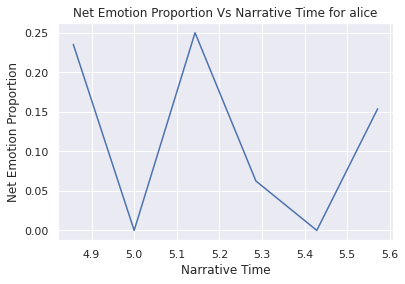

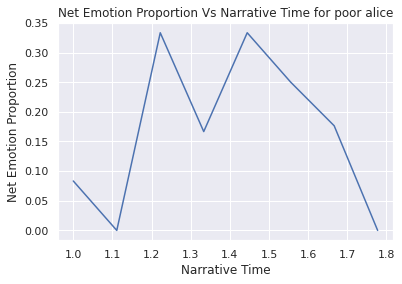

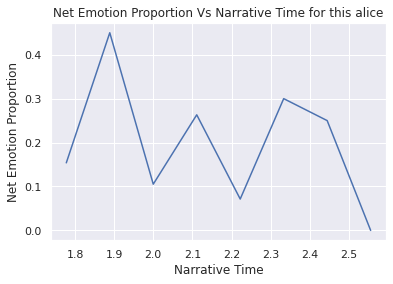

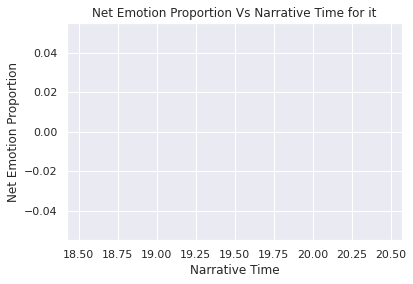

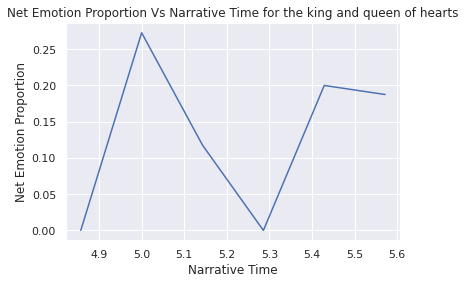

In [65]:
for character in b.top_characters:
    plot_emo(emo_df, b, character)

In [40]:
emo_df = get_emotions(b)
emo_df.head()

,character,paragraph_id,sent_id,global_sent_id,emotion,mini_emotion,emo_prob
0,alice,7,110,1628,neutral,amb,0.999919
1,alice,7,112,1630,neutral,amb,0.999644
2,alice,7,117,1635,admiration,pos,0.995085
3,alice,7,118,1636,desire,pos,0.615530
4,alice,7,120,1638,neutral,amb,0.999979


In [42]:
emo_df['glob_sent_ratio'] = emo_df['global_sent_id']/b.pars[-1].sent_bounds[1]
emo_df['glob_sent_grp'] = (emo_df['glob_sent_ratio']  / 0.025).apply(int)
emo_df.groupby('character').count()

,paragraph_id,sent_id,global_sent_id,emotion,mini_emotion,emo_prob,glob_sent_ratio,glob_sent_grp
character,,,,,,,,
alice,57,57,57,57,57,57,57,57
it,1,1,1,1,1,1,1,1
poor alice,83,83,83,83,83,83,83,83
the king and queen of hearts,81,81,81,81,81,81,81,81
this alice,112,112,112,112,112,112,112,112


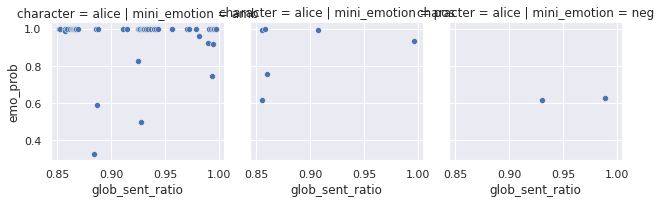

In [43]:
ed = emo_df[emo_df['character'].isin(['alice'])]
# ed = ed[~ed['mini_emotion'].isin(['neutral'])]
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(ed, row="character",col="mini_emotion",# palette="tab20c",
                     )#, 
#                     width=1.5)

# Draw a line plot to show the trajectory of each random walk
# grid.map(plt.plot, "glob_sent_ratio", "emo_prob", marker="o")
grid.map(sns.scatterplot, "glob_sent_ratio", "emo_prob")


In [44]:
ged = ed.groupby(['character','glob_sent_grp','mini_emotion']).agg({'global_sent_id':'count'})
ged = ged/ged.groupby(level=[0,1]).sum()
ged = ged.reset_index()

In [45]:
gedd = ged.pivot(index=['character','glob_sent_grp'], columns='mini_emotion', values='global_sent_id').fillna(0).reset_index()

In [46]:
ged.head()

,character,glob_sent_grp,mini_emotion,global_sent_id
0,alice,34,amb,0.764706
1,alice,34,pos,0.235294
2,alice,35,amb,1.000000
3,alice,36,amb,0.750000
4,alice,36,pos,0.250000


<AxesSubplot:xlabel='glob_sent_grp', ylabel='global_sent_id'>

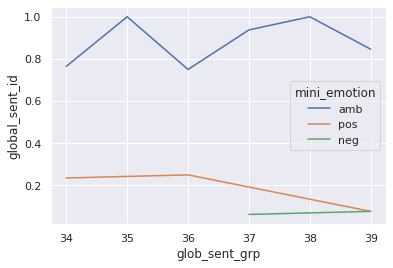

In [47]:
sns.lineplot(x="glob_sent_grp", y="global_sent_id",
             hue="mini_emotion",
             data=ged)

Text(0, 0.5, 'Net Emotion Proportion')

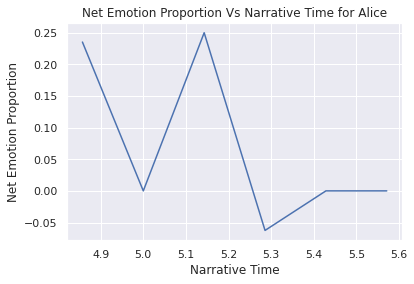

In [49]:
plt.plot(gedd['glob_sent_grp']/(len(gedd)+1),gedd['pos']-gedd['neg'], 'b-')
plt.title('Net Emotion Proportion Vs Narrative Time for Alice')
plt.xlabel('Narrative Time')
plt.ylabel('Net Emotion Proportion')